### Description:  
This is the fourth and last step in the motif conservation analysis (results shown in shown in fig7).  

In this step, we score each motif based on the variant up to which it was found.   
The farther away within the virus's phylogeny that the motif is still found -> the more conserved it is -> the higher its score

In the end we look at motifs that were conserved all the way to new world monkeys as opposed to motifs that were less conserved

### we perform similar process in both dmi motifs and non-dmi motifs  

**reminder:**  
* "non-dmi" is a sequence that matches a regular expression (regex) pattern of a certain motif that was dropped for 1 or 2 reasons:
1. The motif does not match a domain of the human PPIs of said viral protein
2. The average plddt of said motif is higher than 50 

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import fisher_exact

## HSV

Input paths are the output tables from script "03 - create column table" in which we manually moved 4 experimentally-validated motifs from the "non-DMI table" to the "DMI table". These were originally found in our data **in the non-DMI table** of HSV1 because of missing data regarding their interactions in the assembled PPI dataset. They were thus removed from non-DMI and added to the DMI table instead.  
  
**There 2 options of paths to use here:**  
1a. Take the occurrences tables from "03 - create column table", open "experimental motifs.csv" (with the files given), and in the "hsv1" sheet use the "viral_uniprot" and "motif_name" values to search for the appropriate row in the "non_dmi_motifs_OCCURENCES_by_variant" table from script 03.  
Then, add that row to the 'dmi_motifs_OCCURENCES_by_variant' table from script 03.  
The tables are then renamed:    
dmi_motifs_OCCURENCES_by_variant.csv -> dmi_motifs_OCCURENCES_by_variant - with experimental.csv    
non_dmi_motifs_OCCURENCES_by_variant.csv -> non_dmi_motifs_OCCURENCES_by_variant - without experimental.csv  
Or  
1b. Use the occurrences paths given:  
"dmi_motifs_OCCURENCES_by_variant -with experimental.csv" and "non_dmi_motifs_OCCURENCES_by_variant - without experimental.csv".  
These are our results from script "03 - create column table" modified with the changes made with the 4 experimentally-validated motifs.   

In [38]:
hsv_dmi_motifs_path = r"dmi_motifs_OCCURENCES_by_variant -with experimental.csv"
hsv_non_dmi_motifs_path = r"non_dmi_motifs_OCCURENCES_by_variant - without experimental.csv"

In [40]:
hsv_dmi_occur_df = pd.read_csv(hsv_dmi_motifs_path)
hsv_non_dmi_occur_df = pd.read_csv(hsv_non_dmi_motifs_path)

### dmi

In [42]:
# remove motif instances where certain class of variant (ex: old world monkeys) are missing the orthologs for said protein
# no protein -> no data -> remove

columns_to_check1 = ['Macacque HSV1', 'Baboon HSV2', 'Grivet HSV2']
columns_to_check2 = ['squirrel monkey HSV1']

threshold1 = 3
threshold2 = 1

hsv_dmi_occur_df_clean = hsv_dmi_occur_df.dropna(subset=columns_to_check1, thresh=len(columns_to_check1) - threshold1 + 1)
hsv_dmi_occur_df_clean2 = hsv_dmi_occur_df_clean.dropna(subset=columns_to_check2, thresh=len(columns_to_check2) - threshold1 + 1)

In [44]:
# NA can still occur in the data. For example, if out of 3 old world monkeys, we have 1 ortholog, we can use this instance.
# Thus, we convert the NA of "legitimate" instances to 0.
hsv_dmi_occur_df_clean2 = hsv_dmi_occur_df_clean2.fillna(0)

In [46]:
# Create a scoring dictionary.
# Go over each motif, check in which variants in appears (while maintaing a logical conservation order) ans scoring it based on that
# Score can be:
# 0 - only in human (HSV)
# 1 - in human and chimp-infecting viruses 
# 2 - in human, chimp and old world monkeys - infecting viruses 
# 3 - in human, chimp old world monkeys and new world monkeys - infecting viruses

hsv_scoring_dmi_dict={0:0, 1:0,2:0,3:0}

for i in hsv_dmi_occur_df_clean2.index:
    a = int(hsv_dmi_occur_df_clean2.at[i, "Human HSV1"]) 
    b = int(hsv_dmi_occur_df_clean2.at[i, "Human HSV2"]) 
    c = int(hsv_dmi_occur_df_clean2.at[i, "Chimp HSV1"]) 
    d = int(hsv_dmi_occur_df_clean2.at[i, "Macacque HSV1"]) 
    e = int(hsv_dmi_occur_df_clean2.at[i, "Baboon HSV2"]) 
    f = int(hsv_dmi_occur_df_clean2.at[i, "Grivet HSV2"])
    g = int(hsv_dmi_occur_df_clean2.at[i, "squirrel monkey HSV1"]) 

    
    if  a + b == 2 and c == 1 and d+e+f >=2 and g == 1 :
        hsv_scoring_dmi_dict[3] = hsv_scoring_dmi_dict[3] +1

    elif  a + b == 2 and c == 1 and d+e+f >=2 and g == 0 :
         hsv_scoring_dmi_dict[2] = hsv_scoring_dmi_dict[2] +1
          
    elif  a + b <= 2 and c == 1 and d+e+f <2 and g == 0 :
        hsv_scoring_dmi_dict[1] = hsv_scoring_dmi_dict[1] +1
        
    elif  a + b <= 2 and c == 0 and d+e+f <2 and g == 0 :
        hsv_scoring_dmi_dict[0] = hsv_scoring_dmi_dict[0] +1

        
    
 

In [48]:
# Convert the scoring dictionary from counts into percentages

hsv_scoring_dmi_dict_percent={}
hsv_dict_dmi_sum=sum(hsv_scoring_dmi_dict.values())

for key in hsv_scoring_dmi_dict.keys():
    hsv_scoring_dmi_dict_percent[key] = (hsv_scoring_dmi_dict[key]/hsv_dict_dmi_sum) * 100

In [50]:
# Define the new key names (based on the variants class) and their order
hsv_new_keys = ['Human HSV1 only', 'Hominin', 'Great and Old World','Great, Old World, New World']

# Create a new dictionary with the new key names
new_hsv_scoring_dmi_dict_percent_dict = {hsv_new_keys[i]: hsv_scoring_dmi_dict_percent[key] for i, key in enumerate(hsv_scoring_dmi_dict_percent)}

In [52]:
# Convert dictionary to DataFrame
plot_hsv_dmi_df = pd.DataFrame(list(new_hsv_scoring_dmi_dict_percent_dict.items()), columns=['Motif', 'Conservation'])

### non dmi

In [55]:
# Remove motif instances where certain class of vaqriant (ex: old world monkeys) are missing the orthologs for said protein
# no protein -> no data -> remove

columns_to_check1 = ['Macacque HSV1', 'Baboon HSV2', 'Grivet HSV2']
columns_to_check2 = ['squirrel monkey HSV1']

threshold1 = 3
threshold2 = 1

hsv_non_dmi_occur_df_clean = hsv_non_dmi_occur_df.dropna(subset=columns_to_check1, thresh=len(columns_to_check1) - threshold1 + 1)
hsv_non_dmi_occur_df_clean2 = hsv_non_dmi_occur_df_clean.dropna(subset=columns_to_check2, thresh=len(columns_to_check2) - threshold1 + 1)

In [57]:
# NA can be still in the data. for example if out of 3 old world monkeys, we have 1 ortholog. we can use this instance.
#so we convert the NA of legitimate instances to 0
hsv_non_dmi_occur_df_clean2 = hsv_non_dmi_occur_df_clean2.fillna(0)

In [59]:
# Create a scoring dictionary.
# Go over each motif, check in which variants in appears (while maintaing a logical conservation order) ans scoring it based on that
# Score can be:
# 0 - only in human (HSV)
# 1 - in human and chimp-infecting viruses 
# 2 - in human, chimp and old world monkeys - infecting viruses 
# 3 - in human, chimp old world monkeys and new world monkeys - infecting viruses

hsv_scoring_non_dmi_dict={0:0, 1:0,2:0,3:0}

for i in hsv_non_dmi_occur_df_clean2.index:
    a = int(hsv_non_dmi_occur_df_clean2.at[i, "Human HSV1"])
    b = int(hsv_non_dmi_occur_df_clean2.at[i, "Human HSV2"])      
    c = int(hsv_non_dmi_occur_df_clean2.at[i, "Chimp HSV1"]) 
    d = int(hsv_non_dmi_occur_df_clean2.at[i, "Macacque HSV1"]) 
    e = int(hsv_non_dmi_occur_df_clean2.at[i, "Baboon HSV2"]) 
    f = int(hsv_non_dmi_occur_df_clean2.at[i, "Grivet HSV2"])
    g = int(hsv_non_dmi_occur_df_clean2.at[i, "squirrel monkey HSV1"]) 
    
    if a + b == 2 and c == 1 and d+e+f >=2 and g == 1 :
        hsv_scoring_non_dmi_dict[3] = hsv_scoring_non_dmi_dict[3] +1
        
    elif a + b == 2 and c == 1 and d+e+f >=2 and g == 0 :
         hsv_scoring_non_dmi_dict[2] = hsv_scoring_non_dmi_dict[2] +1
        
    elif a + b <= 2 and c == 1 and d+e+f <2 and g == 0 :
        hsv_scoring_non_dmi_dict[1] = hsv_scoring_non_dmi_dict[1] +1
        
    elif a + b <= 2 and c == 0 and d+e+f <2 and g == 0 :
        hsv_scoring_non_dmi_dict[0] = hsv_scoring_non_dmi_dict[0] +1
        
    
 

In [61]:
# Convert the scoring dictionary from counts into percentages

hsv_scoring_non_dmi_dict_percent={}
hsv_dict_non_dmi_sum=sum(hsv_scoring_non_dmi_dict.values())

for key in hsv_scoring_dmi_dict.keys():
    hsv_scoring_non_dmi_dict_percent[key] = (hsv_scoring_non_dmi_dict[key]/hsv_dict_non_dmi_sum) * 100

In [63]:
# Define the new key names (based on the variants class) and their order
hsv_new_keys = ['Human HSV1 only', 'Hominin', 'Great and Old World','Great, Old World, New World']

# Create a new dictionary with the new key names
new_hsv_scoring_non_dmi_dict_percent_dict = {hsv_new_keys[i]: hsv_scoring_non_dmi_dict_percent[key] for i, key in enumerate(hsv_scoring_non_dmi_dict_percent)}

In [65]:
# Convert dictionary to DataFrame
plot_hsv_non_dmi_df = pd.DataFrame(list(new_hsv_scoring_non_dmi_dict_percent_dict.items()), columns=['Motif', 'Conservation'])

### stats - SV motif conservation Fisher's exact

In [68]:
# Insert the counts according to the count dictionaries
# Sum of instances where the motif WAS NOT conserved across all classes 
# The number of instances where the motif WAS conserved across all classes

fisher_df = pd.DataFrame({'dmi':[39, 6], 'non-dmi':[705, 235]}, index=pd.Index(['conserved in all', 'not conserved']))
fisher_df

,dmi,non-dmi
conserved in all,39,705
not conserved,6,235


In [70]:
# Calculate p-value based on Fisher's exact 

oddsr, p = fisher_exact(table=fisher_df.to_numpy())
print(p)

0.0780825967591011


### plot

In [73]:
# Merge both dataframe, of dmi and non dmi
hsv_merged_df = pd.merge(plot_hsv_dmi_df, plot_hsv_non_dmi_df, on='Motif')

In [75]:
# Rename
hsv_merged_df.rename(columns={"Conservation_x":'Functional motifs',"Conservation_y":'Motif sequence matches'} , inplace=True)

In [77]:
# Melt the DataFrame to a long format for seaborn
hsv_merged_plot_df = pd.melt(hsv_merged_df, id_vars='Motif', value_vars=['Functional motifs', 'Motif sequence matches'], 
                         var_name='Source', value_name='Value')

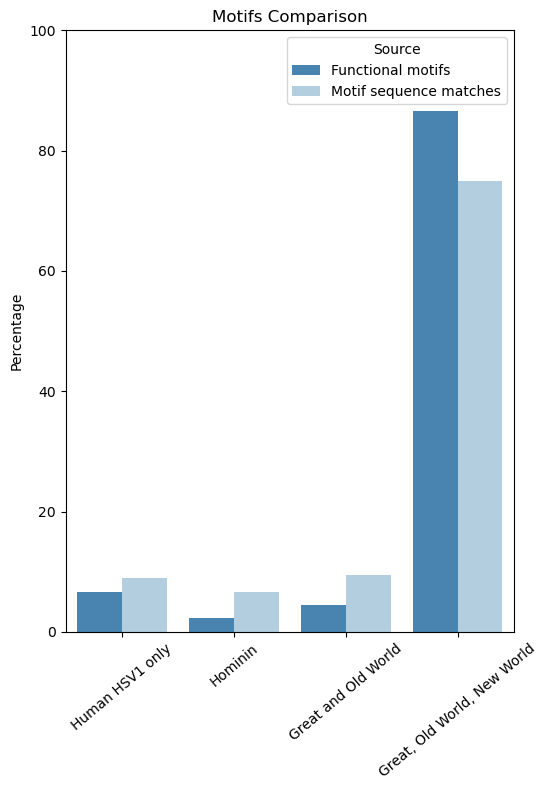

In [79]:
# Set the size of the plot
plt.figure(figsize=(5.6, 8))

# Create the bar plot with Seaborn
sns.barplot(x='Motif', y='Value', hue='Source', data=hsv_merged_plot_df, 
            palette='Blues_r')

# Customize the plot
plt.ylabel('Percentage')
plt.xlabel('')
plt.ylim(0, 100)
plt.xticks(rotation=40)
plt.title('Motifs Comparison')

plt.tight_layout()
plt.show()